In [1]:
#Import Dependencies
import json
import requests
from citipy import citipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import timedelta,datetime,date

In [2]:
#Google and Open Weather API import from file
from config import ow_api_key

#Starting date for date/time converstion from UTC values
st = datetime(1899,12,31)

In [3]:
#list of cities wasw published on OpenWeatherMap.org so I imported the data
city_list="http://openweathermap.org/help/city_list.txt"
city_df= pd.read_table(city_list, encoding="windows-1252")
city_df["countryCode"]=city_df["countryCode"].str.lower()

In [4]:
#1600 cities sampled from the imported city_list
city_samp=city_df
city_samp=city_samp.sample(n=850)
city_samp.reset_index()
#city_delt = city_df[~city_df.isin(city_samp)].dropna()
#alt_cities=city_delt["nm"].to_dict()
cities=[]
cities_id= city_samp["id"].to_dict()
cities=city_samp["nm"]

In [5]:
url="http://api.openweathermap.org/data/2.5/weather?"
units="imperial"
query_url= url+"appid="+ow_api_key+"&units="+units+"&q="
plot_data=pd.DataFrame({"city_id":[],"city":[],"lon":[],"lat":[],"temp":[],"humid_perc":[],"clouds":[],"wind_mph":[]})

In [6]:
#storage arrays for data results
city_nm=[]
city_id=[]
cntry=[]
w_date=[]
lon=[]
lat=[]
temp=[]
max_temp=[]
humid=[]
clouds=[]
wind=[]
city_err=[]
json_dumps=[]

In [7]:
rec_cnt=1
print("API DATA FROM OPENWEATHER RETRIVEAL STARTING")
print("""-------------------------------------------------------------------------------------------------------------------------""")
start_time=time.time()
for city in cities:
    try:
        j_url= query_url+city
        response=requests.get(j_url).json()
        #print(json.dumps(response, indent=4, sort_keys=True))
        city_id.append(response["id"])
        city_nm.append(response["name"])
        cntry.append(response["sys"]["country"])
        w_date.append(st+timedelta(days=(response["dt"]/86400)+25569))
        lon.append(float(response["coord"]["lon"]/1))
        lat.append(float(response["coord"]["lat"]/1))
        temp.append(float(response["main"]["temp"]/1))
        max_temp.append(float(response["main"]["temp_max"]))
        humid.append(float(response["main"]["humidity"]/1))
        clouds.append(float(response["clouds"]["all"]))
        wind.append(float(response["wind"]["speed"])*2.23694)
        json_dumps.append(requests.get(j_url).json())
        print("""-------------------------------------------------------------------------------------------------------------------------""")
        print("Retriving set %s of %s." %(rec_cnt,len(cities)))
        print("""-------------------------------------------------------------------------------------------------------------------------""")
        print("For %s (city ID: %s) the response URL is:\n%s"%(city,response["id"],j_url))
        print("\n")
        print("""-------------------------------------------------------------------------------------------------------------------------""")
        rec_cnt=rec_cnt+1
    except KeyError:
        print("""*************************************************************************************************************************""")
        print("Failed to retrieve set %s of %s:" %(rec_cnt,len(cities)))
        print("\t%s does not provide the necessary data elements"%(city))
        print("""*************************************************************************************************************************""")
        print("\n")
        rec_cnt=rec_cnt+1
        city_err.append(city)
    except TypeError:
        print("Type error on record {0:05} of API Request".format(rec_cnt))
        rec_cnt=rec_cnt+1
print("""-------------------------------------------------------------------------------------------------------------------------""")
print("API DATA FROM OPENWEATHER RETRIVEAL COMPLETE. (elapsed time: %s seconds)" %(round(time.time()-start_time,3)))
max_d= str(max(w_date))
print("Latest data as of:"+max_d+" of API Request")

API DATA FROM OPENWEATHER RETRIVEAL STARTING
-------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------
Retriving set 1 of 850.
-------------------------------------------------------------------------------------------------------------------------
For Alexeni (city ID: 665010) the response URL is:
http://api.openweathermap.org/data/2.5/weather?appid=342be2d87aa1a01ee23d2f18e71b767e&units=imperial&q=Alexeni


-------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------
Retriving set 2 of 850.
-------------------------------------------------------------------------------------------------------------------------
For Maravat

In [8]:
#Displays a summary of the data pulled that was usable vs. unusable
print("""~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~""")
print("| Total Cities found: {0:,}\t\t\t\t\t\t\t\t\t\t\t\t|".format(len(city_nm)+len(city_err)))
print("| Total Cities Usable: {0:,}\t\t\t\t\t\t\t\t\t\t\t\t|".format(len(city_nm)))
print("| Total Cities Unusabled: {0:,}\t\t\t\t\t\t\t\t\t\t\t\t|".format(len(city_err)))
print("""~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~""")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
| Total Cities found: 850												|
| Total Cities Usable: 846												|
| Total Cities Unusabled: 4												|
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [9]:
#Create a dataframe to hold all of the data pulled from the API
data_plot=pd.DataFrame(np.column_stack([city_nm,  city_id,  cntry,w_date,  lon,  lat,  temp,  max_temp, humid,  clouds,  wind,]),
                       columns=["city","id","countryCD","date","lon","lat","temp","maxTemp","humidity %","clouds","windSpeed_MPH"])
data_plot=data_plot.dropna(how="any")
#data_plot.head()

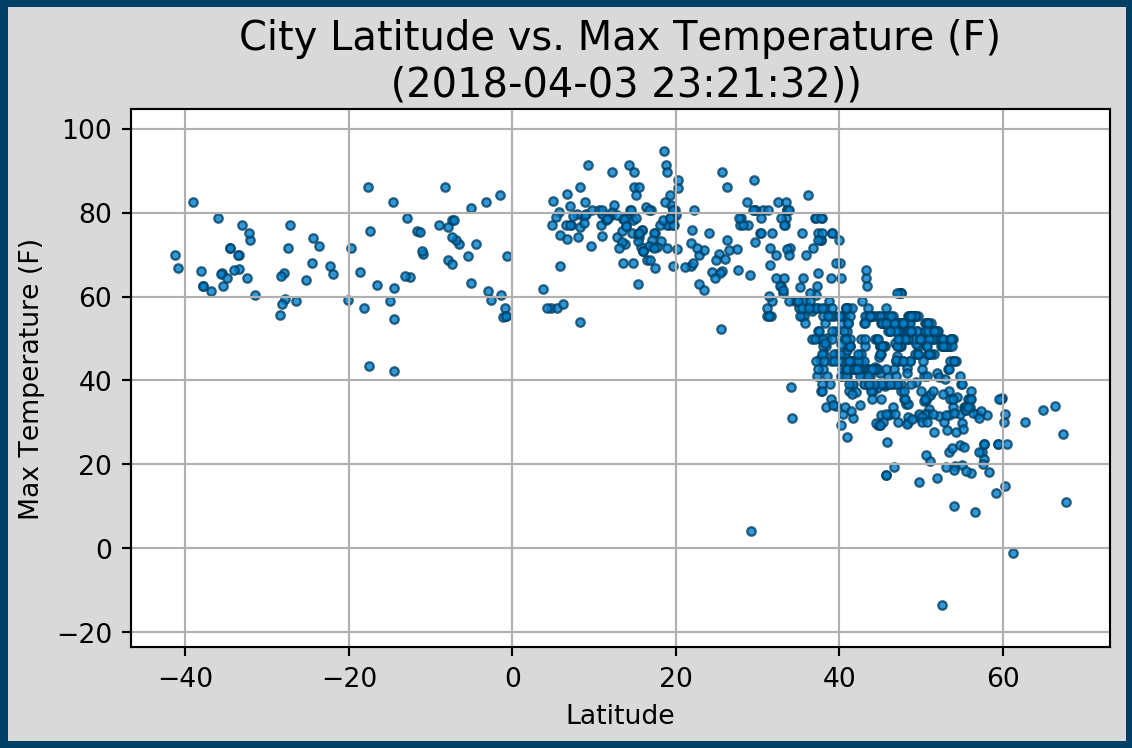

In [10]:
#Generate Latitude vs Temperature scatterplot
x_t_axis = data_plot["lat"]
y_t_axis = data_plot["maxTemp"]
fig, ax = plt.subplots(dpi=192)
plt.grid(True)
fig.patch.set_facecolor("#d9d9d9")
fig.patch.set_edgecolor("#004065")
fig.patch.set_linewidth(5)
ax.scatter(x_t_axis,
           y_t_axis, 
           marker="o",
           alpha=0.8, 
           edgecolors="#004065", 
           color="#0080CC",
           linewidths=.85,
           s=10)
plt.ylim([min(x_t_axis)-10, max(x_t_axis)+10])
plt.ylim([min(y_t_axis)-10, max(y_t_axis)+10])
ax.set_xlabel("Latitude",fontsize=10,)
ax.set_ylabel("Max Temperature (F)", fontsize=10)
ax.set_title("City Latitude vs. Max Temperature (F)\n ({0:}))".format(max_d), fontsize=15,pad=5)

fig.tight_layout()
fig.savefig('Latitude_v_Temp.png')

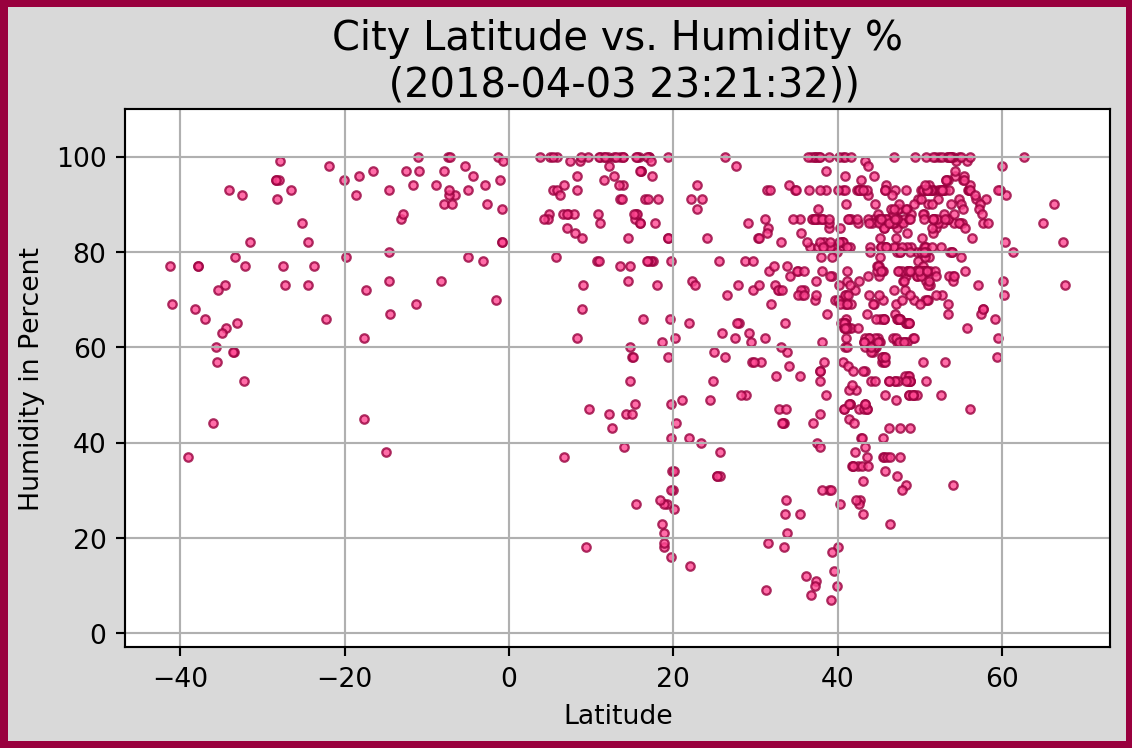

In [11]:
#Generate City Latitude vs. Humidity scatterplot
x_h_axis = data_plot["lat"]
y_h_axis = data_plot["humidity %"]
fig, ax = plt.subplots(dpi=192)
fig.patch.set_facecolor("#d9d9d9")
fig.patch.set_edgecolor("#99003E")
fig.patch.set_linewidth(5)
ax.scatter(x_h_axis,
           y_h_axis, 
           marker="o",
           alpha=0.8, 
           edgecolors="#99003E", 
           color="#FF4892",
           linewidths=.85,
           s=10)
plt.grid(True)
plt.ylim([min(x_h_axis)-10, max(x_h_axis)+10])
plt.ylim([min(y_h_axis)-10, max(y_h_axis)+10])
#plt.ylim([-2.5, 102])
ax.set_xlabel("Latitude",fontsize=10,)
ax.set_ylabel("Humidity in Percent", fontsize=10)
ax.set_title("City Latitude vs. Humidity %\n ({0:}))".format(max_d), fontsize=15,pad=5)
fig.tight_layout()
fig.savefig('Latitude_v_Humidity.png')

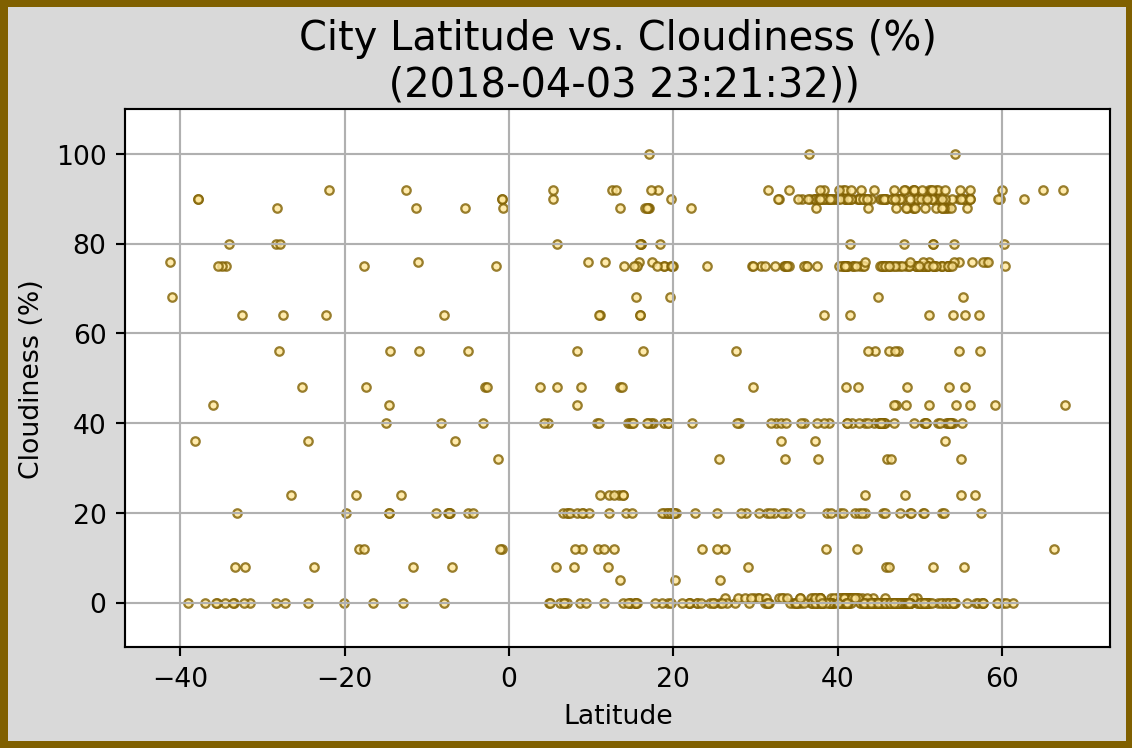

In [12]:
#Generate City Latitude vs. Cloudiness
x_c_axis = data_plot["lat"]
y_c_axis = data_plot["clouds"]
fig, ax = plt.subplots(dpi=192)
fig.patch.set_facecolor("#d9d9d9")
fig.patch.set_edgecolor("#806000")
fig.patch.set_linewidth(5)
ax.scatter(x_c_axis,
           y_c_axis, 
           marker="o",
           alpha=0.8, 
           edgecolors="#806000", 
           color="#FFE699",
           linewidths=.85,
           s=10)
plt.grid(True)
plt.ylim([min(x_c_axis)-10, max(x_c_axis)+10])
plt.ylim([min(y_c_axis)-10, max(y_c_axis)+10])
#plt.ylim([-2.5, 102])
ax.set_xlabel("Latitude",fontsize=10,)
ax.set_ylabel("Cloudiness (%)", fontsize=10)
ax.set_title("City Latitude vs. Cloudiness (%)\n ({0:}))".format(max_d), fontsize=15,pad=5)
fig.tight_layout()
fig.savefig('Latitude_v_Cloud.png')

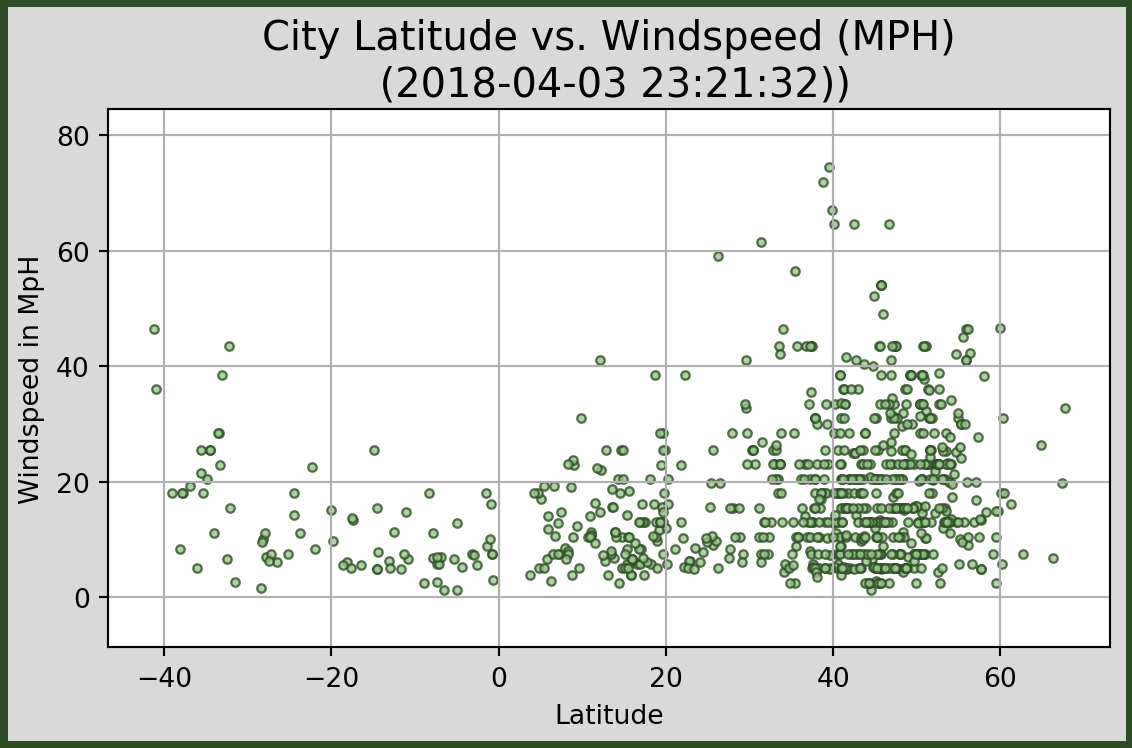

In [13]:
#Generate City Latitude vs. Windspeed (MPH)
x_ws_axis = data_plot["lat"]
y_ws_axis = data_plot["windSpeed_MPH"]
fig, ax = plt.subplots(dpi=192)
fig.patch.set_facecolor("#d9d9d9")
fig.patch.set_edgecolor("#2D4D24")
fig.patch.set_linewidth(5)
ax.scatter(x_ws_axis,
           y_ws_axis, 
           marker="o",
           alpha=0.8, 
           edgecolors="#2D4D24", 
           color="#97C88A",
           linewidths=.85,
           s=10)
plt.grid(True)
plt.ylim([min(x_ws_axis)-10, max(x_ws_axis)+10])
plt.ylim([min(y_ws_axis)-10, max(y_ws_axis)+10])
#plt.ylim([-2.5, 102])
ax.set_xlabel("Latitude",fontsize=10,)
ax.set_ylabel("Windspeed in MpH", fontsize=10)
ax.set_title("City Latitude vs. Windspeed (MPH)\n ({0:}))".format(max_d), fontsize=15,pad=5)
fig.tight_layout()
fig.savefig('Latitude_v_Windspeed.png')

In [14]:
#Data Output generation

city_df.to_csv("city_df.csv", index=False, header=True)
city_samp.to_csv("city_samp.csv", index=False, header=True)
city_err= pd.DataFrame(city_err)
city_err.to_csv("city_err.csv", index=False, header=True)
data_plot.to_csv("data_plot.csv", index=False, header=True)